<a href="https://colab.research.google.com/github/KOCORA/-Basic_Attention.ipynb/blob/master/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_Basic_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Базовый процесс механизма внимания

Как вы уже знаете, механизм внимания позволяет декодеру seq2seq использовать информацию из каждого слова на входе кодировщика, а не только последнее скрытое состояние кодировщика, как в классических рекуррентных моделях. В процессе внимания выходы кодировщика взвешиваются, базируясь на скрытом состоянии декодера, после чего объединяются в один вектор контекста. Затем этот вектор используется в качестве входа декодера для прогнозирования следующего шага вывода.


В этой лабораторной работе без оценки вы реализуете базовый процесс внимания, как описано в [Bhadanau, et al (2014)](https://arxiv.org/abs/1409.0473)

Вы создадите нейронную сеть из двух слоёв без использования специальных инструментов `tensorflow` и `keras`, а только лишь при помощи операций библиотеки `numpy`. Это позволит вам подробнее познакомиться с внутренним устройством слоёв нейронных сетей на простых примерах.

 Каждый шаг, который вы будете кодировать, подробно описан, вам остается только прочитать и перевести на `python`.

In [1]:
# Сначала запустите эту небольшую настройку для остальной части лабораторной
import numpy as np

def softmax(x, axis=0):
    """ Вычисляет функцию softmax для массива x вдоль указанных осей координат

        axis=0 softmax вычисляется по строкам, это означает, что сумма по каждой колонке будет равна 1
        axis=1 softmax вычисляется по колонкам, это означает, что сумма по каждой строке будет равна 1
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

## 1: Расчет баллов alignment (выравнивания)

Баллы alignment - мера сходства между текущим скрытым состоянием декодера и каждым скрытым состоянием кодировщика. В статье эта операция выглядит как
$$
\large e_{ij} = v_a^\top \tanh{\left(W_a s_{i-1} + U_a h_j\right)}
$$

где $W_a \in \mathbb{R}^{n\times m}$, $U_a \in \mathbb{R}^{n \times m}$, и $v_a \in \mathbb{R}^m$ -  матрицы весов  слоёв, а $n$ - размер скрытого состояния. На практике это реализуется как нейронная сеть прямого хода с двумя слоями, где $m$ - количество нейронов в каждом слое сети alignment и выглядит примерно так:

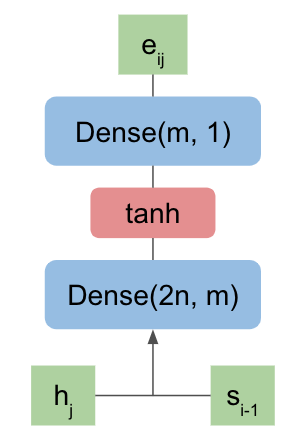

где \
$h_j$ - скрытые состояния кодировщика для каждого шага ввода $j$,\
$s_{i - 1}$ - скрытое состояние декодера на предыдущем шаге.\
веса первого слоя dense соответствуют $W_a$ и $U_a$ из формулы, веса второго слоя dense - $v_a$.

Реализация:
1. Конкатенацией скрытых состояний кодировщика и декодера создайте массив с размером $K \times 2n$ где $K$ - количество шагов (состояний) кодировщика. Для этого используется `np.concatenate` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)). Имейте в виду, что у декодера есть только **одно** состояние, поэтому вам нужно изменить его `shape`, чтобы успешно объединить массивы. Самое простое - использовать `decoder_state.repeat` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy.repeat)) для получения одинаковых размеров массивов скрытых состояний.
2. примените первый слой как матричное умножение между весами и объединенным входом. Используйте функцию `tanh`, в качестве активации.
3. вычислив матричное умножение весов второго слоя и полученных активаций, вы получите баллы alignment.


In [2]:
hidden_size = 16
attention_size = 10
input_length = 5


np.random.seed(42)

# синтезированные векторы для тестирования
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Веса для нейронной сети обычно обучаются в процессе обучения нейронной сети.
# Используйте их в функции выверки (alignment) как веса слоя.
layer_1 = np.random.randn(2*hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

# Реализация функции выверки.
def alignment(encoder_states, decoder_state):

    # конкатенация состояния кодировщика и состояния декодера

    inputs = np.concatenate((encoder_states, decoder_state.repeat(input_length, axis = 0)), axis = 1)
    #######################
    assert inputs.shape == (input_length, 2*hidden_size)

    # Матричное умножение объединенного входа и layer_1, с последующей активацией tanh
    #ЗДЕСЬ ВАШ КОД
    activations = np.tanh(np.matmul(inputs, layer_1))
    #######################
    assert activations.shape == (input_length, attention_size)

    # Матричное умножение полученных активаций и layer_2. Помните, что tanh здесь уже не нужен
    #ЗДЕСЬ ВАШ КОД
    scores = np.matmul(activations, layer_2)
    #######################
    assert scores.shape == (input_length, 1)

    return scores

In [3]:
# Проверка функции выверки
scores = alignment(encoder_states, decoder_state)
print(scores)

[[4.35790943]
 [5.92373433]
 [4.18673175]
 [2.11437202]
 [0.95767155]]


Ожидаемый вывод:

```python
[[4.35790943]
 [5.92373433]
 [4.18673175]
 [2.11437202]
 [0.95767155]]
```

## 2: Превращение баллов выверки в веса:

Следующий шаг - вычисление весов по баллам выверки. Эти веса определяют выходы кодировщика, наиболее важные для выхода декодера. Эти веса должны быть между 0 и 1 и в сумме равны 1. Вы можете использовать функцию `softmax` (уже реализована выше), чтобы получить эти веса из оценок внимания. Вектор баллов внимания передаётся функции `softmax`. Математически, это

$$
\large \alpha_{ij} = \frac{\exp{\left(e_{ij}\right)}}{\sum_{k=1}^K \exp{\left(e_{ik}\right)}}
$$

## 3: Взвесьте выходные векторы кодировщика и просуммируйте

Веса говорят вам о важности каждого входного слова по отношению к состоянию декодера. На этом этапе вы используете веса для модуляции величины векторов кодировщика. Влияние слов с меньшей важностью будут уменьшены по сравнению с более важными словами. Для этого каждый вектор кодировщика умножается на соответствующий вес. Затем  полученные взвешенные векторы выверки суммируются, чтобы получить вектор контекста. Математически,

$$
\large c_i = \sum_{j=1}^K\alpha_{ij} h_{j}
$$

Реализуйте эти шаги в функции `attention`:

In [4]:
def attention(encoder_states, decoder_state):
    """ Пример функции, вычисляющей внимание и возвращающей вектор контекста

        Arguments:
        encoder_vectors: N x M numpy-вектор, где N - количество векторов и M длина вектора
        decoder_vector: 1 x M numpy-вектор, M длина вектора, такая же как у encoder_vectors
    """

    # 1. Вычисление баллов выверки

    #######################
    scores = scores = alignment(encoder_states, decoder_state)

    # 2. Пропустить баллы выверки через функцию softmax для получения распределения весов

    weights = softmax(scores)
    #######################

    # Умножить каждое состояние кодировщика на соответствующий вес

    weighted_scores = np.dot(encoder_states.T, weights)
    #######################

    # Суммировать взвешенные баллы выверки для получения вектора контекста

    context = np.sum(weighted_scores, axis=1)
    #######################
    return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]


Ожидаемый вывод:

```python
[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]
```

